In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import gsw
import scipy.io as si
from scipy.optimize import fmin
from scipy.signal import savgol_filter
from netCDF4 import Dataset
import pickle
import datetime
import pickle
# functions I've written 
from glider_cross_section import Glider
from mode_decompositions import eta_fit, vertical_modes, PE_Tide_GM, vertical_modes_f
from toolkit import spectrum_fit, nanseg_interp, plot_pro, find_nearest

# matplotlib.rcParams['figure.figsize'] = (14,10)

# --- PHYSICAL PARAMETERS
g = 9.81
rho0 = 1025  # - 1027
ref_lat = 31.7
ref_lon = 64.2
f_ref = np.pi * np.sin(np.deg2rad(ref_lat)) / (12 * 1800)
# --- MODE PARAMETERS
# frequency zeroed for geostrophic modes
omega = 0
# highest baroclinic mode to be calculated
mmax = 45
nmodes = mmax + 1
# maximum allowed deep shear [m/s/km]
deep_shr_max = 0.1
# minimum depth for which shear is limited [m]
deep_shr_max_dep = 3500
eta_fit_depth_min = 250
eta_fit_depth_max = 4250  # 3900
# --- BIN PARAMETERS
GD = Dataset('BATs_2015_gridded_apr04.nc', 'r')
bin_depth = GD.variables['grid'][:]

# ----------------------------------------------------------------------------------------------------------------------
# ---- PROCESSING USING GLIDER PACKAGE
gs = 46
ge = 120
x = Glider(37, np.arange(gs, ge + 1), '/Users/jake/Documents/seaglider/dg037_bermuda_19/fm_reprocessing_nov19/')

box = np.array([[30.595, 69.9725], [31.405, 69.9725], [31.405, 69.0275], [30.595, 69.0275]])  # SW, NW, NE, SE (corners)
box_mid = np.array([[30.595, 69.5], [31, 69.9725], [31.405, 69.5], [31, 69.0275]])  # S, W, N, E (mids)
bbi = [1, box, box_mid]

# Test alternate density computation
import_dg = si.loadmat('/Users/jake/Documents/baroclinic_modes/sg037_2019_neutral_density_bin.mat')
dg_data = import_dg['out']
limm = 490
profile_tags_0 = dg_data['prof_number'][0][0][0]
if profile_tags_0[0] == gs:
    first = 0
else:
    first = np.where(profile_tags_0 < gs)[0][-1] + 1
if profile_tags_0[-1] == ge + 0.5:
    last = len(profile_tags_0)
else:
    last = np.where(profile_tags_0 > ge)[0][0] 
d_in = range(first, last)
profile_tags = profile_tags_0[d_in]
neutral_density = dg_data['Neut_den'][0][0][0:limm, d_in]
t = dg_data['Temp'][0][0][0:limm, d_in]
s = dg_data['Sal'][0][0][0:limm, d_in]
lon = dg_data['Lon'][0][0][0:limm, d_in]
lat = dg_data['Lat'][0][0][0:limm, d_in]
dac_u = dg_data['Dac_u'][0][0][0][d_in]
dac_v = dg_data['Dac_v'][0][0][0][d_in]
mw_lon = np.nanmean(lon, axis=0)
mw_lat = np.nanmean(lat, axis=0)
d_time = dg_data['Time'][0][0][0:limm, d_in] - 366
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
ref_lat = np.nanmean(lat)
time_rec_bin = np.nanmean(d_time, axis=0)
grid = dg_data['Depth'][0][0][0:limm, 0]
grid_p = gsw.p_from_z(-1 * grid, ref_lat)
grid_p[0] = 0
z = -1 * grid
sz_g = grid.shape[0]

In [4]:
# load bathy
bath = '/Users/jake/Desktop/bats/bats_bathymetry/etopo180_3e57_6032_17e3.nc'
bath_fid = Dataset(bath, 'r')
bath_lon = bath_fid.variables['longitude'][:]
bath_lat = bath_fid.variables['latitude'][:]
bath_z = bath_fid.variables['altitude'][:]
levels = [-5500, -5400, -5300, -5200, -5100, -5000, -4900, -4800]

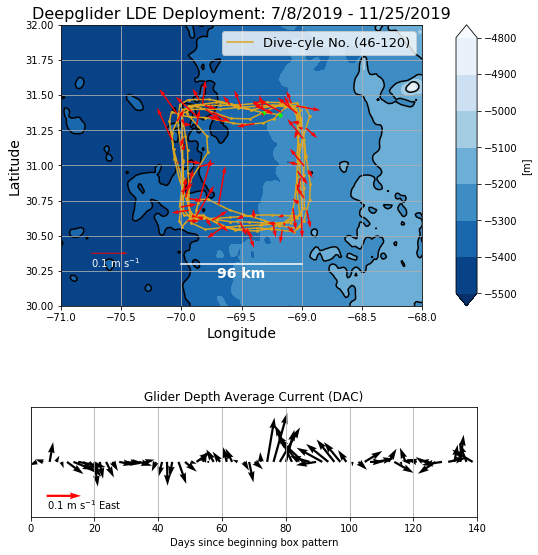

In [5]:
# PLAN VIEW PLOt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

matplotlib.rcParams['figure.figsize'] = (8, 8)
fig = plt.figure(figsize=(8, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])
cmap = plt.cm.get_cmap("Blues_r")
bc = ax0.contourf(bath_lon, bath_lat, bath_z, levels, cmap='Blues_r', extend='both', zorder=0)
matplotlib.rcParams['contour.negative_linestyle'] = 'solid'
bcl = ax0.contour(bath_lon, bath_lat, bath_z, [-5400, -5200, -5000, -4800], colors='k', zorder=1)
ax0.clabel(bcl, inline_spacing=-3, fmt='%1.0f', colors='k')

ax0.scatter(mw_lon, mw_lat, s=3, color='#DAA520')
ax0.scatter(mw_lon[-2:], mw_lat[-2:], s=10, color='#00FF00', zorder=2)
ax0.plot(mw_lon, mw_lat, color='#DAA520',
        label='Dive-cyle No. (' + str(int(profile_tags[0])) + '-' + str(int(profile_tags[-2])) + ')', zorder=1)

tdu = np.nan * np.ones(np.int(np.nanmax(np.floor(profile_tags)) - np.nanmin(np.floor(profile_tags))) + 1)
tdv = np.nan * np.ones(np.int(np.nanmax(np.floor(profile_tags)) - np.nanmin(np.floor(profile_tags))) + 1)
tlon = np.nan * np.ones(np.int(np.nanmax(np.floor(profile_tags)) - np.nanmin(np.floor(profile_tags))) + 1)
tlat = np.nan * np.ones(np.int(np.nanmax(np.floor(profile_tags)) - np.nanmin(np.floor(profile_tags))) + 1)
tt = np.nan * np.ones(np.int(np.nanmax(np.floor(profile_tags)) - np.nanmin(np.floor(profile_tags))) + 1)
count = 0
for i in range(0, np.shape(dac_u)[0], 2):
    tdu[count] = dac_u[i]
    tdv[count] = dac_v[i]
    tlon[count] = np.nanmean(mw_lon[i:i+2])
    tlat[count] = np.nanmean(mw_lat[i:i+2])
    tt[count] = np.nanmean(time_rec_bin[i:i+2])
    count = count + 1

ax0.quiver(tlon, tlat, tdu, tdv, color='r', scale=1.3, width=0.004, zorder=2)
ax0.quiver(-70.75, 30.375, 0.1, 0, color='r', scale=1, width=0.0025, zorder=2)
ax0.text(-70.75, 30.27, r'0.1 m s$^{-1}$', color='w' )

ax0.plot([-70, -69], [30.3, 30.3], color='w', zorder=2)
ax0.text(-69.7, 30.2, '96 km', color='w', fontsize=14, fontweight='bold')

w = 1 / np.cos(np.deg2rad(ref_lat))
ax0.set_aspect(w)
ax0.set_xlim([-71, -68])
ax0.set_ylim([30, 32])
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(bc, cax=cax, label='[m]')
ax0.set_xlabel('Longitude', fontsize=14)
ax0.set_ylabel('Latitude', fontsize=14)
handles, labels = ax0.get_legend_handles_labels()
ax0.legend(handles, labels, fontsize=13)
ax0.set_title('Deepglider LDE Deployment: ' + np.str(t_s.month) + '/' + np.str(t_s.day) + '/' + np.str(
    t_s.year) + ' - ' + np.str(t_e.month) + '/' + np.str(t_e.day) + '/' + np.str(t_e.year), fontsize=16)
# plt.tight_layout()
ax0.grid()

ax1.quiver(tt - np.nanmin(tt), np.zeros(len(tdu)), tdu, tdv, scale=1.4, width=0.005) 
ax1.set_xlim([0, 140])
ax1.set_xlabel('Days since beginning box pattern')
ax1.set_title('Glider Depth Average Current (DAC)')
ax1.quiver(5, -.17, 0.1, 0, color='r', scale=1.3, width=0.005, zorder=2)
ax1.text(5, -.24, r'0.1 m s$^{-1}$ East', color='k' )
ax1.set_ylim([-.275, .275])
ax1.axes.get_yaxis().set_ticks([])
plot_pro(ax1)
fig.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/LDE_bathy_dac.jpg", dpi=300)

In [7]:
# -- Compute density
sa, ct, theta, sig0, sig2, dg_N2 = x.density(grid, ref_lat, t, s, lon, lat)

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: Mean of empty slice
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: Mean of empty slice


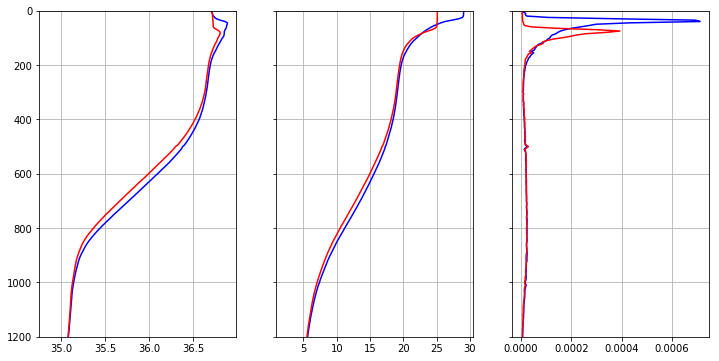

()

In [9]:
matplotlib.rcParams['figure.figsize'] = (12, 6)
f, (ax, ax2, ax3) = plt.subplots(1, 3, sharey=True)
# ax.plot(np.nanmean(s[:, 0:20], axis=1), grid, color='k')
ax.plot(np.nanmean(s[:, 40:70], axis=1), grid, color='b')
ax.plot(np.nanmean(s[:, -20:], axis=1), grid, color='r')
ax.set_ylim([0, 1200])
ax.invert_yaxis()
ax.grid()
# ax2.plot(np.nanmean(t[:, 0:20], axis=1), grid, color='k')
ax2.plot(np.nanmean(t[:, 40:70], axis=1), grid, color='b')
ax2.plot(np.nanmean(t[:, -20:], axis=1), grid, color='r')
ax2.grid()
# ax3.plot(np.nanmean(dg_N2[:, 0:20], axis=1), grid, color='k')
ax3.plot(np.nanmean(dg_N2[:, 40:70], axis=1), grid, color='b')
ax3.plot(np.nanmean(dg_N2[:, -20:], axis=1), grid, color='r')
plot_pro(ax3)

In [10]:
t_s = datetime.date.fromordinal(np.int(np.nanmin(d_time)))
t_e = datetime.date.fromordinal(np.int(np.nanmax(d_time)))
t_e

datetime.date(2019, 11, 25)

In [11]:
# -- Background density profiles and (seasonal variability, not yet for 37) 
# Season Boundaries 
bd1 = 735750  # (time_rec_bin < bd1) & 
bd2 = 735856  # 

# split to account for horizontal gradients (should split for onshore/offshore of bermuda)
lon_lim = -69.5  # mid_split in lon
lat_lim = 31.0   # mid_split in lat 
# four boxes will be top left to bottom right clockwise 

# Winter 
d_1 = np.where((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim)))[0]
d_2 = np.where((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) > lat_lim)))[0]
d_3 = np.where((np.nanmean(lon, axis=0) > lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim)))[0]
d_4 = np.where((np.nanmean(lon, axis=0) < lon_lim) & ((np.nanmean(lat, axis=0) < lat_lim)))[0]

bckgrds = [d_1, d_2, d_3, d_4]
bckgrds_info = ['b_1', 'b_2', 'b_3', 'b_4']

# ABOVE SETS ORDER OF N2 PROFILES (different that order at the end)

salin_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
cons_t_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
sigma_theta_avg = np.nan * np.zeros((len(grid), len(bckgrds)))
ddz_avg_sigma = np.nan * np.zeros((len(grid), len(bckgrds)))
N2_0 = np.nan * np.zeros(sigma_theta_avg.shape)
N2_ref = np.nan * np.zeros(sigma_theta_avg.shape)
N = np.nan * np.zeros(sigma_theta_avg.shape)
for i in range(len(bckgrds)):
    inn = bckgrds[i]
    salin_avg[:, i] = np.nanmean(sa[:, inn], axis=1)
    cons_t_avg[:, i] = np.nanmean(ct[:, inn], axis=1)
    theta_avg[:, i] = np.nanmean(theta[:, inn], axis=1)
    sigma_theta_avg[:, i] = np.nanmean(neutral_density[:, inn], axis=1)
    ddz_avg_sigma[:, i] = np.gradient(sigma_theta_avg[:, i], z)
    go = ~np.isnan(salin_avg[:, i])
    N2_0[np.where(go)[0][0:-1], i] = gsw.Nsquared(salin_avg[go, i], cons_t_avg[go, i], grid_p[go], lat=ref_lat)[0]
    N2_0[N2_0[:, i] < 0] = np.nan  # 1 * 10**-7
    N2_ref[:, i] = nanseg_interp(grid, N2_0[:, i])
    # N2_ref[:, i] = savgol_filter(N2_ref[:, i], 5, 3)
N2_ref[-1, :] = N2_ref[-2, :] - 1 * 10**-9
N2 = N2_ref.copy()

N2_all = np.nan * np.zeros(len(grid))
N2_all[0:-1] = gsw.Nsquared(np.nanmean(salin_avg, axis=1), np.nanmean(cons_t_avg, axis=1), grid_p, lat=ref_lat)[0]
N2_all[-2:] = N2_all[-3]
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
N_all = np.sqrt(N2_all)
N2_all = savgol_filter(N2_all, 5, 3)
N2_all[N2_all < 0] = np.nan
N2_all = nanseg_interp(grid, N2_all)
still_nan = np.where(np.isnan(N2_all))[0]
for i in range(len(still_nan)):
    N2_all[still_nan[i]] = N2_all[still_nan[i] - 1] - 0.00000002

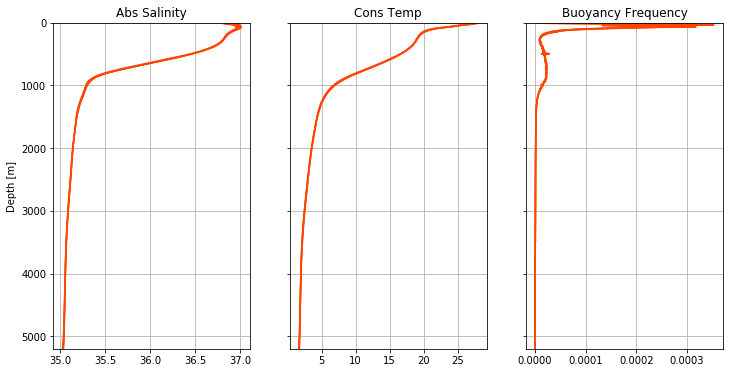

()

In [12]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
coli = '#FF4500', '#FF4500', '#FF4500', '#FF4500', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#2F4F4F', '#DAA520', '#DAA520', '#DAA520', '#DAA520'
# cols = ['#2F4F4F', '#FF4500', '#DAA520']
# season_labs = ['Feb-Apr', 'May-Sept', 'Sept-Nov']
for i in range(len(bckgrds)):
    ax1.plot(salin_avg[:, i], grid, color=coli[i])
    ax2.plot(cons_t_avg[:, i], grid, color=coli[i])
    ax3.plot(N2_ref[:, i], grid, color=coli[i])
ax1.set_ylim([0, 5200])
ax1.grid()
ax2.grid()
ax1.invert_yaxis()
# ax1.set_xlim([-.05, .05])
ax1.set_ylabel('Depth [m]')
ax1.set_title('Abs Salinity')
# ax2.set_xlim([-.4, .4])
ax2.set_title('Cons Temp')
# ax3.set_xlim([-.00001, .00001])
ax3.set_title('Buoyancy Frequency')
plot_pro(ax3)

In [13]:
# -- compute M/W sections and compute velocity
# -- USING X.TRANSECT_CROSS_SECTION_1 (THIS WILL SEPARATE TRANSECTS BY TARGET OF EACH DIVE)
sigth_levels = np.concatenate(
    [np.arange(23, 26.5, 0.5), np.arange(26.2, 27.2, 0.2),
     np.arange(27.2, 27.7, 0.2), np.arange(27.7, 28, 0.02), np.arange(28, 28.15, 0.01)])
# sigth_levels = np.concatenate([np.aranger(32, 36.6, 0.2), np.arange(36.6, 36.8, 0.05), np.arange(36.8, 37.4, 0.02)])

# --- SAVE so that we dont have to run transects every time
savee = 1
if savee > 0:
    partial = 0  # permit partial M estimates at the start/end of transects 
    ds, dist, avg_ct_per_dep_0, avg_sa_per_dep_0, avg_sig0_per_dep_0, v_g, vbt, \
        isopycdep, isopycx, mwe_lon, mwe_lat, DACe_MW, DACn_MW, profile_tags_per, \
            shear, box_side, v_g_east, v_g_north = x.transect_cross_section_1(grid, neutral_density, 
                                                                               ct, sa, lon, lat,
                                                                               dac_u, dac_v,
                                                                               profile_tags,
                                                                               sigth_levels, partial, bbi)
    my_dict = {'ds': ds, 'dist': dist, 'avg_ct_per_dep_0': avg_ct_per_dep_0,
               'avg_sa_per_dep_0': avg_sa_per_dep_0, 'avg_sig0_per_dep_0': avg_sig0_per_dep_0, 'v_g': v_g, 'vbt': vbt,
               'isopycdep': isopycdep, 'isopycx': isopycx, 'mwe_lon': mwe_lon, 'mwe_lat': mwe_lat, 'DACe_MW': DACe_MW,
               'DACn_MW': DACn_MW, 'profile_tags_per': profile_tags_per, 
               'v_g_east': v_g_east, 'v_g_north': v_g_north, 'box_side': box_side}
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_transects.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
else:
    pkl_file = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_transects.pkl', 'rb')
    B15 = pickle.load(pkl_file)
    pkl_file.close()
    ds = B15['ds']
    dist = B15['dist']
    avg_ct_per_dep_0 = B15['avg_ct_per_dep_0']
    avg_sa_per_dep_0 = B15['avg_sa_per_dep_0']
    avg_sig0_per_dep_0 = B15['avg_sig0_per_dep_0']
    v_g = B15['v_g']
    v_g_east = B15['v_g_east']
    v_g_north = B15['v_g_north']
    box_side = B15['box_side']
    vbt = B15['vbt']
    isopycdep = B15['isopycdep']
    isopycx = B15['isopycx']
    mwe_lon = B15['mwe_lon']
    mwe_lat = B15['mwe_lat']
    DACe_MW = B15['DACe_MW']
    DACn_MW = B15['DACn_MW']
    profile_tags_per = B15['profile_tags_per']

# unpack velocity profiles from transect analysis
dace_mw_0 = DACe_MW[0][0:-1].copy()
dacn_mw_0 = DACn_MW[0][0:-1].copy()
dg_v_0 = v_g[0][:, 0:-1].copy()
dg_v_e_0 = v_g_east[0][:, 0:-1].copy()
dg_v_n_0 = v_g_north[0][:, 0:-1].copy()
avg_sig0_per_dep = avg_sig0_per_dep_0[0].copy()
avg_ct_per_dep = avg_ct_per_dep_0[0].copy()
avg_sa_per_dep = avg_sa_per_dep_0[0].copy()
dg_v_lon = mwe_lon[0][0:-1].copy()
dg_v_lat = mwe_lat[0][0:-1].copy()
dg_v_dive_no_0 = profile_tags_per[0][0:-1].copy()
box_side_0 = box_side[0] * np.ones((1, len(v_g[0][10, 0:-1])))
for i in range(1, len(v_g)):
    dace_mw_0 = np.concatenate((dace_mw_0, DACe_MW[i][0:-1]), axis=0)
    dacn_mw_0 = np.concatenate((dacn_mw_0, DACn_MW[i][0:-1]), axis=0)
    dg_v_0 = np.concatenate((dg_v_0, v_g[i][:, 0:-1]), axis=1)
    dg_v_e_0 = np.concatenate((dg_v_e_0, v_g_east[i][:, 0:-1]), axis=1)
    dg_v_n_0 = np.concatenate((dg_v_n_0, v_g_north[i][:, 0:-1]), axis=1)
    avg_ct_per_dep = np.concatenate((avg_ct_per_dep, avg_ct_per_dep_0[i]), axis=1)
    avg_sa_per_dep = np.concatenate((avg_sa_per_dep, avg_sa_per_dep_0[i]), axis=1)
    avg_sig0_per_dep = np.concatenate((avg_sig0_per_dep, avg_sig0_per_dep_0[i]), axis=1)
    dg_v_lon = np.concatenate((dg_v_lon, mwe_lon[i][0:-1]))
    dg_v_lat = np.concatenate((dg_v_lat, mwe_lat[i][0:-1]))
    dg_v_dive_no_0 = np.concatenate((dg_v_dive_no_0, profile_tags_per[i][0:-1]))
    box_side_0 = np.concatenate((box_side_0, box_side[i] * np.ones((1, len(v_g[i][10, 0:-1])))), axis=1)
    

# Time matching to eta/v profiles
count = 0
for i in range(0, len(profile_tags_per)):
    these_dives = profile_tags_per[i]
    for j in range(len(these_dives) - 1):
        tin = time_rec_bin[np.in1d(profile_tags, these_dives[j:j+2])]
        if count < 1:
            dg_mw_time_0 = np.array([np.nanmean(tin)])
        else:
            dg_mw_time_0 = np.concatenate((dg_mw_time_0, np.array([np.nanmean(tin)])))
        count = count + 1
        
prof_lon_i = np.nanmean(lon, axis=0)
prof_lat_i = np.nanmean(lat, axis=0)     

transects = [[9, 10, 11], [21, 22, 23], [35, 36, 37], [50, 51, 52, 53], [64, 65, 66]]
[9, 10, 11]
index_start = 18
index_end = 24
dive cycles in this transect = [ 55.   55.5  56.   56.5  57.   57.5]


/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:616: RuntimeWarning: Mean of empty slice
  sigma_theta_pa_W[j] = np.nanmean(sigmathetaW)  # average density across 4 profiles
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:617: RuntimeWarning: Mean of empty slice
  lon_pa_W[j] = np.nanmean(lon[j, c_i_w])  # avg lat/lon across M/W profiles
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:618: RuntimeWarning: Mean of empty slice
  lat_pa_W[j] = np.nanmean(lon[j, c_i_w])
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:684: RuntimeWarning: Mean of empty slice
  info[1, i] = np.nanmean(lon_pa_M)
/Users/jake/Documents/geostrophic_turbulence/glider_cross_section.py:685: RuntimeWarning: Mean of empty slice
  info[2, i] = np.nanmean(lat_pa_M)


profile # = [ 55.   55.5  56.   56.5  57. ]
[21, 22, 23]
index_start = 42
index_end = 48
dive cycles in this transect = [ 67.   67.5  68.   68.5  69.   69.5]
profile # = [ 67.   67.5  68.   68.5  69. ]
[35, 36, 37]
index_start = 70
index_end = 76
dive cycles in this transect = [ 81.   81.5  82.   82.5  83.   83.5]
profile # = [ 81.   81.5  82.   82.5  83. ]
[50, 51, 52, 53]
index_start = 100
index_end = 108
dive cycles in this transect = [ 96.   96.5  97.   97.5  98.   98.5  99.   99.5]
profile # = [ 96.   96.5  97.   97.5  98.   98.5  99. ]
[64, 65, 66]
index_start = 128
index_end = 134
dive cycles in this transect = [ 110.   110.5  111.   111.5  112.   112.5]
profile # = [ 110.   110.5  111.   111.5  112. ]
transects = [[0, 1, 2], [12, 13, 14], [24, 25, 26, 27], [38, 39, 40, 41, 42], [54, 55, 56, 57], [67, 68]]
[0, 1, 2]
index_start = 0
index_end = 6
dive cycles in this transect = [ 46.   46.5  47.   47.5  48.   48.5]
profile # = [ 46.   46.5  47.   47.5  48. ]
[12, 13, 14]
index_sta

In [31]:
np.shape(dg_v_0)

(490, 104)

In [11]:
# successfully split box pattern into segments
# need to look at velocities into/out of box (try for exchange)
# need orientation (+ velocity to port, unique to ACW direction)
# look at velocity structure u vs. v (anisotropy?), spectra for each 

[3.0, 0.0, 0.0, 2.0, 1.0]

In [62]:
# for now average all profiles (should be able to do better now)
# salin_avg = np.nanmean(salin_avg, axis=1)
# cons_t_avg = np.nanmean(cons_t_avg, axis=1)
# theta_avg = np.nanmean(theta_avg, axis=1)
# sigma_theta_avg = np.nanmean(sigma_theta_avg, axis=1)
# ddz_avg_sigma = np.nanmean(ddz_avg_sigma, axis=1)
# N2 = np.nanmean(N2, axis=1)

In [14]:
# Eta from M/W method, which produces an average density per set of profiles
eta_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_2 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
eta_alt_3 = np.nan * np.ones(np.shape(avg_sig0_per_dep))
d_anom_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
gradient_alt = np.nan * np.ones(np.shape(avg_sig0_per_dep))
for i in range(np.shape(avg_sig0_per_dep)[1]):  # loop over each profile
    # check if it is a column of nan's (these would arise it we omit a partial M/W estimate...which we do)
    if np.nansum(np.isnan(avg_sig0_per_dep[:, i])) < 30:
        # (average of four profiles) - (total long term average, that is seasonal)
        this_time = dg_mw_time_0[i]
        this_lon = dg_v_lon[i]
        this_lat = dg_v_lat[i]
        # match profile with appropriate background (in time and space)

        # adjustment for now (some robust background averages per quadrant, but no time variability)    
        # first sort by quadrant 
        # quadrant 1 
        if (this_lon < lon_lim) & (this_lat > lat_lim): 
            # if this_time < bd1: # winter 
            #     t_over = 0  
            # elif (this_time > bd1) & (this_time < bd2):  # summer 
            #     t_over = 4  
            # else:  # fall 
            #     t_over = 8  
            salin_avg_i = salin_avg[:, 0]
            cons_t_avg_i = cons_t_avg[:, 0] 
            theta_avg_i = theta_avg[:, 0] 
            sigma_theta_avg_i = sigma_theta_avg[:, 0]
            ddz_avg_sigma_i = ddz_avg_sigma[:, 0]
            N2_i = N2[:, 0]     
        # quadrant 2        
        elif (this_lon > lon_lim) & (this_lat > lat_lim):  
            # if this_time < bd1: # winter 
            #     t_over = 1  
            # elif (this_time > bd1) & (this_time < bd2):  # summer 
            #     t_over = 5  
            # else:  # fall 
            #     t_over = 9    
            salin_avg_i = salin_avg[:, 1]
            cons_t_avg_i = cons_t_avg[:, 1] 
            theta_avg_i = theta_avg[:, 1] 
            sigma_theta_avg_i = sigma_theta_avg[:, 1]
            ddz_avg_sigma_i = ddz_avg_sigma[:, 1]
            N2_i = N2[:, 1]           
        # quadrant 3        
        elif (this_lon > lon_lim) & (this_lat < lat_lim):
            # if this_time < bd1: # winter 
            #     t_over = 2  
            # elif (this_time > bd1) & (this_time < bd2):  # summer 
            #     t_over = 6  
            # else:  # fall 
            #     t_over = 10  
            salin_avg_i = salin_avg[:, 2]
            cons_t_avg_i = cons_t_avg[:, 2] 
            theta_avg_i = theta_avg[:, 2] 
            sigma_theta_avg_i = sigma_theta_avg[:, 2]
            ddz_avg_sigma_i = ddz_avg_sigma[:, 2]
            N2_i = N2[:, 2]        
        # quadrant 4        
        else:
            # if this_time < bd1: # winter 
            #     t_over = 3 
            # elif (this_time > bd1) & (this_time < bd2):  # summer 
            #     t_over = 7  
            # else:  # fall 
            #     t_over = 11  
            salin_avg_i = salin_avg[:, 3]
            cons_t_avg_i = cons_t_avg[:, 3] 
            theta_avg_i = theta_avg[:, 3] 
            sigma_theta_avg_i = sigma_theta_avg[:, 3]
            ddz_avg_sigma_i = ddz_avg_sigma[:, 3]
            N2_i = N2[:, 3]           

        # ETA ALT (avg_sig0_per_dep and sigma_theta_avg are really neutral density, imported from matlab binning)
        # match profile (really avg of 3/4 profiles) with one of 4 seasonal background profiles
        # adjustment for now because we only have one background profile     
        #     this_sigma_theta_avg = sigma_theta_avg[:, t_over]
        #     eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
        #     d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg[:, t_over])    
        this_sigma_theta_avg = sigma_theta_avg_i
        eta_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg_i) / np.squeeze(ddz_avg_sigma_i)
        d_anom_alt[:, i] = (avg_sig0_per_dep[:, i] - sigma_theta_avg_i)  
            
        # ETA ALT 2
        # find appropriate average background profiles
        avg_a_salin = salin_avg_i  # [:, t_over]
        avg_c_temp = cons_t_avg_i  # [:, t_over]

        # compute density at every depth for every profile using sa and ct profiles (really avg of 3/4 profiles)
        # eta_alt_2 is compute using a local reference pressure
        # loop over each bin depth
        for j in range(2, len(grid) - 2):
            if ~np.isnan(avg_sa_per_dep[j, i]):
                # profile density at depth j with local reference pressure (call p2)
                this_sigma = gsw.rho(avg_sa_per_dep[j, i], avg_ct_per_dep[j, i], grid_p[j]) - 1000      # profile density
                # background density at points above and below p2 with local reference pressure (p2)
                this_sigma_avg = gsw.rho(avg_a_salin[j-2:j+3], avg_c_temp[j-2:j+3], grid_p[j]) - 1000
                d_anom_alt[j, i] = this_sigma - this_sigma_avg[1]
                gradient_alt[j, i] = np.nanmean(np.gradient(this_sigma_avg, z[j-2:j+3]))
                # gradient_alt[j, i] = (this_sigma_avg[0] - this_sigma_avg[2]) / (grid[j-1] - grid[j+1])
                eta_alt_2[j, i] = d_anom_alt[j, i] / gradient_alt[j, i]

        # ETA ALT 3
        this_rho = avg_sig0_per_dep[:, i]
        this_rho_good = ~np.isnan(this_rho)
        for j in range(len(this_rho_good)):
            # find this profile density at j along avg profile
            # if there are nans in the mean density profile 
            # bi1 = np.where(np.isnan(this_sigma_theta_avg))[0][0]
            # idx, rho_idx = find_nearest(this_sigma_theta_avg[0:bi1], avg_sig0_per_dep[j, i])
            idx, rho_idx = find_nearest(this_sigma_theta_avg, avg_sig0_per_dep[j, i])
            if idx <= 2:
                z_rho_1 = grid[0:idx + 3]
                eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[0:idx + 3], z_rho_1) - grid[j]
            else:
                z_rho_1 = grid[idx - 2:idx + 3]
                eta_alt_3[j, i] = np.interp(avg_sig0_per_dep[j, i], this_sigma_theta_avg[idx - 2:idx + 3], z_rho_1) - grid[j]
        # print(i)
                
# eta_alt = gamma / ddz 
# eta_alt_2 = local potential density / local ddz 
# eta_alt_3 = direct search for gamma on background profile (difference in depths then computed)
eta_alt_0 = eta_alt.copy()

In [15]:
# --- ETA COMPUTED FROM INDIVIDUAL DENSITY PROFILES (AND PE from function)
G_all, Gz_all, c_all, epsilon_all = vertical_modes(N2_all, grid, omega, mmax)
eta_per_prof = np.nan * np.ones(sig2.shape)
eta_per_prof_3 = np.nan * np.ones(sig2.shape)
d_anom_prof = np.nan * np.ones(sig2.shape)
Eta_m_prof = np.nan * np.zeros(np.shape(eta_per_prof_3))
PE_per_mass_prof = np.nan * np.zeros([nmodes, np.shape(eta_per_prof_3)[1]])
for i in range(lon.shape[1]):
    this_lon = np.nanmean(lon[:, i])
    this_lat = np.nanmean(lat[:, i])
    this_time = np.nanmean(d_time[:, i])    
    
    # adjustment for now (some robust background averages per quadrant, but no time variability)    
    # first sort by quadrant 
    # quadrant 1 
    if (this_lon < lon_lim) & (this_lat > lat_lim): 
        # if this_time < bd1: # winter 
        #     t_over = 0  
        # elif (this_time > bd1) & (this_time < bd2):  # summer 
        #     t_over = 4  
        # else:  # fall 
        #     t_over = 8  
        salin_avg_i = salin_avg[:, 0]
        cons_t_avg_i = cons_t_avg[:, 0] 
        theta_avg_i = theta_avg[:, 0] 
        sigma_theta_avg_i = sigma_theta_avg[:, 0]
        ddz_avg_sigma_i = ddz_avg_sigma[:, 0]
        N2_i = N2[:, 0]     
    # quadrant 2        
    elif (this_lon > lon_lim) & (this_lat > lat_lim):  
        # if this_time < bd1: # winter 
        #     t_over = 1  
        # elif (this_time > bd1) & (this_time < bd2):  # summer 
        #     t_over = 5  
        # else:  # fall 
        #     t_over = 9    
        salin_avg_i = salin_avg[:, 1]
        cons_t_avg_i = cons_t_avg[:, 1] 
        theta_avg_i = theta_avg[:, 1] 
        sigma_theta_avg_i = sigma_theta_avg[:, 1]
        ddz_avg_sigma_i = ddz_avg_sigma[:, 1]
        N2_i = N2[:, 1]           
    # quadrant 3        
    elif (this_lon > lon_lim) & (this_lat < lat_lim):
        # if this_time < bd1: # winter 
        #     t_over = 2  
        # elif (this_time > bd1) & (this_time < bd2):  # summer 
        #     t_over = 6  
        # else:  # fall 
        #     t_over = 10  
        salin_avg_i = salin_avg[:, 2]
        cons_t_avg_i = cons_t_avg[:, 2] 
        theta_avg_i = theta_avg[:, 2] 
        sigma_theta_avg_i = sigma_theta_avg[:, 2]
        ddz_avg_sigma_i = ddz_avg_sigma[:, 2]
        N2_i = N2[:, 2]        
    # quadrant 4        
    else:
        # if this_time < bd1: # winter 
        #     t_over = 3 
        # elif (this_time > bd1) & (this_time < bd2):  # summer 
        #     t_over = 7  
        # else:  # fall 
        #     t_over = 11  
        salin_avg_i = salin_avg[:, 3]
        cons_t_avg_i = cons_t_avg[:, 3] 
        theta_avg_i = theta_avg[:, 3] 
        sigma_theta_avg_i = sigma_theta_avg[:, 3]
        ddz_avg_sigma_i = ddz_avg_sigma[:, 3]
        N2_i = N2[:, 3]   

#     this_sigma_theta_avg = sigma_theta_avg[:, t_over]
#     eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over]) / np.squeeze(ddz_avg_sigma[:, t_over])
#     d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg[:, t_over])
    this_sigma_theta_avg = sigma_theta_avg_i
    eta_per_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg_i) / np.squeeze(ddz_avg_sigma_i)
    d_anom_prof[:, i] = (neutral_density[:, i] - sigma_theta_avg_i)
    
    # ETA ALT 3
    # try a new way to compute vertical displacement
    for j in range(len(grid)):
        # find this profile density at j along avg profile
        # bi1 = np.where(np.isnan(this_sigma_theta_avg))[0][0]
        idx, rho_idx = find_nearest(this_sigma_theta_avg, neutral_density[j, i])
        if idx <= 3:
            z_rho_1 = grid[0:idx + 4]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[0:idx + 4],
                                             z_rho_1) - grid[j]
        else:
            z_rho_1 = grid[idx - 3:idx + 4]
            eta_per_prof_3[j, i] = np.interp(neutral_density[j, i], this_sigma_theta_avg[idx - 3:idx + 4],
                                             z_rho_1) - grid[j]
         
    N2_each = N2_i  # [:, t_over].copy()            
    n2nan = np.where(np.isnan(N2_each))[0]
    for nn in n2nan:
        N2_each[nn] = N2_each[nn - 1] - 0.000000001
    G_this, Gz_this, c_this, epsilon_this = vertical_modes(N2_each, grid, omega, mmax)
    
    this_eta = eta_per_prof_3[:, i].copy()
    bvf = np.sqrt(N2_each)
    Neta = np.nan * np.zeros(np.shape(this_eta))
    NEta_m = np.nan * np.zeros(np.shape(this_eta))
    AG_prof = np.zeros([nmodes, 1])
    eta_fs = this_eta.copy()  # ETA
    # obtain matrix of NEta
    # old, Neta[:, i] = bvf * this_eta
    # find indices within fitting range
    iw = np.where((grid >= eta_fit_depth_min) & (grid <= eta_fit_depth_max))[0]
    if iw.size > 1:
        i_sh = np.where((grid < eta_fit_depth_min))
        eta_fs[i_sh[0]] = grid[i_sh] * this_eta[iw[0]] / grid[iw[0]]

        # i_dp = np.where((grid > eta_fit_dep_max))
        # eta_fs[i_dp[0]] = (grid[i_dp] - grid[-1]) * this_eta[iw[0][-1]] / (grid[iw[0][-1]] - grid[-1])
        # -- taper fit as z approaches -H
        i_dp = np.where((grid > eta_fit_depth_max))[0]
        lgs = grid[iw[-1]]
        grid_ar = np.nan * np.ones(len(i_dp))
        for oo in range(len(grid[i_dp])):
            grid_ar[oo] = np.int(grid[i_dp[oo]])
        eta_fs[i_dp] = (grid_ar - np.int(grid[-1])) * this_eta[iw[-1]] / (np.int(lgs) - grid[-1])

        AG_prof[1:, 0] = np.squeeze(np.linalg.lstsq(G_this[:, 1:], eta_fs)[0])
        # AG[1:, i] = np.squeeze(np.linalg.lstsq(G[:, 1:], np.transpose(np.atleast_2d(eta_fs)))[0])
        NEta_m = bvf * np.array(np.squeeze(np.matrix(G_this) * np.transpose(np.matrix(AG_prof[:, 0]))))
        Eta_m_prof[:, i] = np.squeeze(np.matrix(G_this) * np.transpose(np.matrix(AG_prof[:, 0])))
        PE_per_mass_prof[:, i] = 0.5 * AG_prof[:, 0] * AG_prof[:, 0] * c_this * c_this

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:253: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [35]:
np.shape(neutral_density)

(490, 122)

In [22]:
PE_per_mass_all = PE_per_mass_prof.copy()
PE_all_time = np.nanmean(d_time, axis=0)
PE_all_tags = profile_tags.copy()

In [16]:
# look at u,v 
# box completed in clockwise pattern 
# positive velocity is to port of glider 
#
#     ___2____
#    |       |
#    |       |
#   1|       |3 
#    |_______|
#        0 
#
u = np.concatenate([-1.0 * dg_v_0[:, box_side_0[0,:] == 1], dg_v_0[:, box_side_0[0,:] == 3]], axis=1)
v = np.concatenate([-1.0 * dg_v_0[:, box_side_0[0,:] == 0], dg_v_0[:, box_side_0[0,:] == 2]], axis=1)
u_prof = np.concatenate([dg_v_dive_no_0[box_side_0[0,:] == 1], dg_v_dive_no_0[box_side_0[0,:] == 3]])
v_prof = np.concatenate([dg_v_dive_no_0[box_side_0[0,:] == 0], dg_v_dive_no_0[box_side_0[0,:] == 2]])
dace_u_side = np.concatenate([dace_mw_0[box_side_0[0, :] == 1], dace_mw_0[box_side_0[0, :] == 3]])
dacn_u_side = np.concatenate([dacn_mw_0[box_side_0[0, :] == 1], dacn_mw_0[box_side_0[0, :] == 3]])
dace_v_side = np.concatenate([dace_mw_0[box_side_0[0, :] == 0], dace_mw_0[box_side_0[0, :] == 2]])
dacn_v_side = np.concatenate([dace_mw_0[box_side_0[0, :] == 0], dace_mw_0[box_side_0[0, :] == 2]])
time_order = np.argsort(u_prof)
u_prof = u_prof[time_order]
u = u[:, time_order]
dace_u_side = dace_u_side[time_order]
dacn_u_side = dacn_u_side[time_order]
time_order = np.argsort(v_prof)
v_prof = v_prof[time_order]
v = v[:, time_order]
dace_v_side = dace_v_side[time_order]
dacn_v_side = dacn_v_side[time_order]

In [15]:
ref_lat = 31.0
ref_lon = -69.5
# velocity profile x,y 
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (dg_v_lon - ref_lon)
y = 1852 * 60 * (dg_v_lat - ref_lat)
# slant-profile x,y 
x_d = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (lon - ref_lon)
y_d = 1852 * 60 * (lat - ref_lat)

u_1 = -1.0 * dg_v_0[:, box_side_0[0,:] == 1]
y_1 = y[box_side_0[0,:] == 1]
u_1_no = dg_v_dive_no_0[box_side_0[0,:] == 1]
u_3 = 1.0 * dg_v_0[:, box_side_0[0,:] == 3]
y_3 = y[box_side_0[0,:] == 3]
u_3_no = dg_v_dive_no_0[box_side_0[0,:] == 3]
v_0 = -1.0 * dg_v_0[:, box_side_0[0,:] == 0]
x_0 = x[box_side_0[0,:] == 0]
v_0_no = dg_v_dive_no_0[box_side_0[0,:] == 0]
v_2 = 1.0 * dg_v_0[:, box_side_0[0,:] == 2]
x_2 = x[box_side_0[0,:] == 2]
v_2_no = dg_v_dive_no_0[box_side_0[0,:] == 2]

# filter off partial M/W 
# yy_1 = y[box_side_0[0,:] == 1][1:-1]
# uu_1 = u_1[:, 1:-1]
# yy_3 = y[box_side_0[0,:] == 3][1:-1]
# uu_3 = u_3[:, 1:-1]
# xx_0 = x[box_side_0[0,:] == 0][1:-1]
# vv_0 = v_0[:, 1:-1]
# xx_2 = x[box_side_0[0,:] == 2][1:-1]
# vv_2 = v_2[:, 1:-1]

# indicies for velocity profiles in u_1 etc 
u_1_br = [0]
for i in range(1, len(u_1_no)):
    if (u_1_no[i] - u_1_no[i - 1]) > 2:
        u_1_br.append(i)
u_3_br = [0]
for i in range(1, len(u_3_no)):
    if (u_3_no[i] - u_3_no[i - 1]) > 2:
        u_3_br.append(i)
v_0_br = [0]
for i in range(1, len(v_0_no)):
    if (v_0_no[i] - v_0_no[i - 1]) > 2:
        v_0_br.append(i)
v_2_br = [0]
for i in range(1, len(v_2_no)):
    if (v_2_no[i] - v_2_no[i - 1]) > 2:
        v_2_br.append(i)       
u_1_br.append(len(u_1_no))  
u_3_br.append(len(u_3_no)) 
v_0_br.append(len(v_0_no)) 
v_2_br.append(len(v_2_no)) 
print(u_1_br) 
print(u_3_br)
print(v_0_br)
print(v_2_br)

[0, 5, 10, 15, 20, 25]
[0, 5, 10, 15, 22, 27]
[0, 5, 10, 17, 26, 33, 36]
[0, 5, 10, 17, 24, 29]


In [159]:
print(y_1[u_1_br[m]:u_1_br[m+1]]/1000)
print(np.nanmean(y_d[:, ind_p_in]/1000, axis=0))
this_v0

[-22.59131774  -3.62264664  12.24277588  28.49370321  35.25814779]
[-40.039387   -39.12502903 -39.34382684 -41.08295749 -41.8818196
 -42.36569714]


array([[        nan,  0.16441774,  0.12317031,  0.10972236,         nan],
       [        nan,  0.16596494,  0.12452597,  0.1115572 ,         nan],
       [        nan,  0.16724314,  0.12491084,  0.11291264,         nan],
       ..., 
       [        nan, -0.03378123, -0.03244844, -0.01543809,         nan],
       [        nan, -0.03489962, -0.03164117, -0.01531619,         nan],
       [        nan, -0.03629293, -0.02984143, -0.01522413,         nan]])

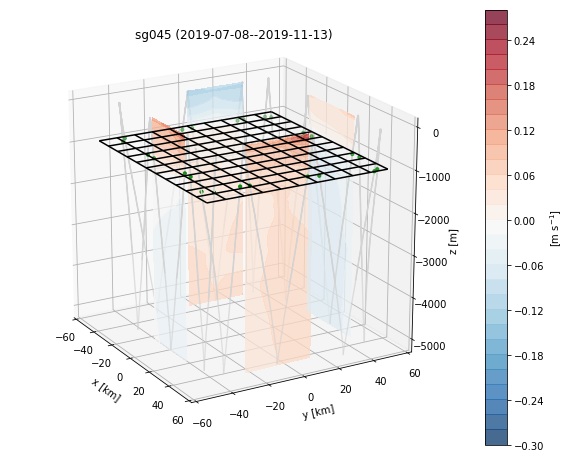

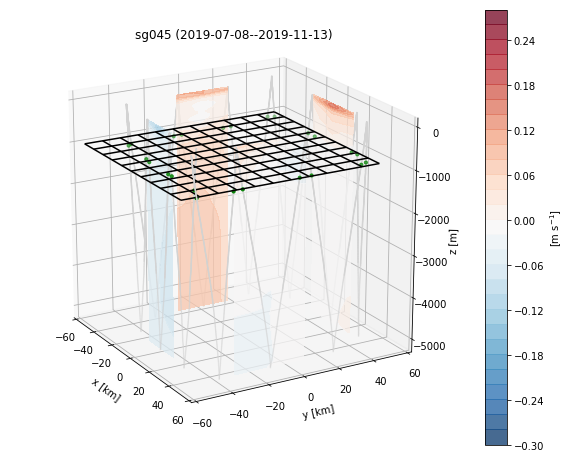

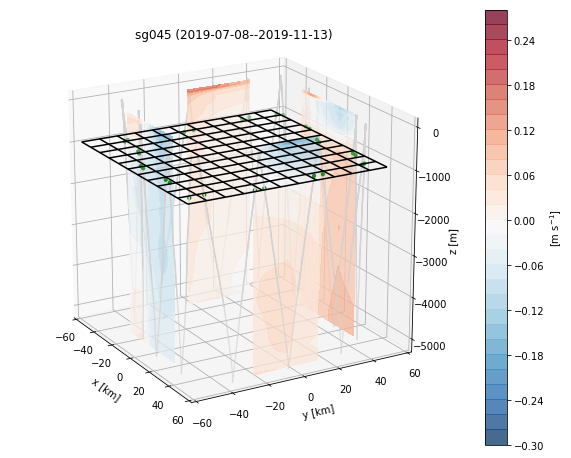

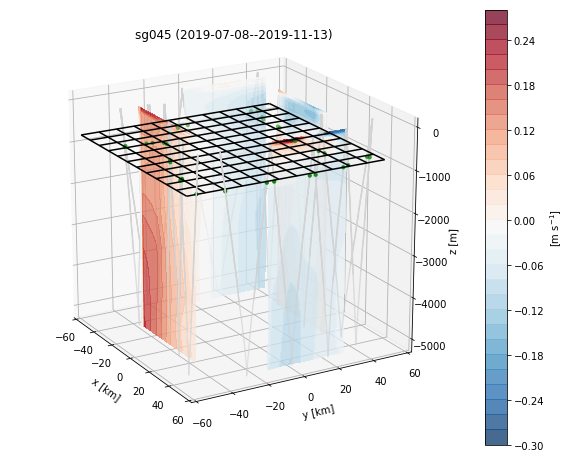

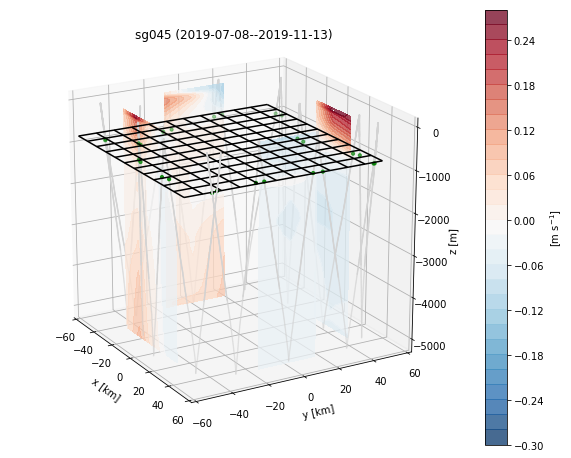

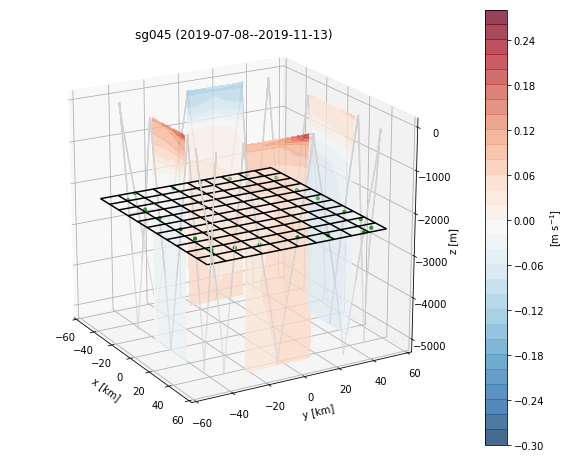

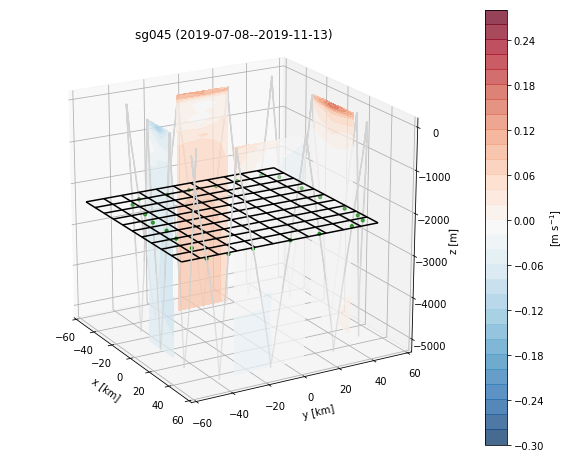

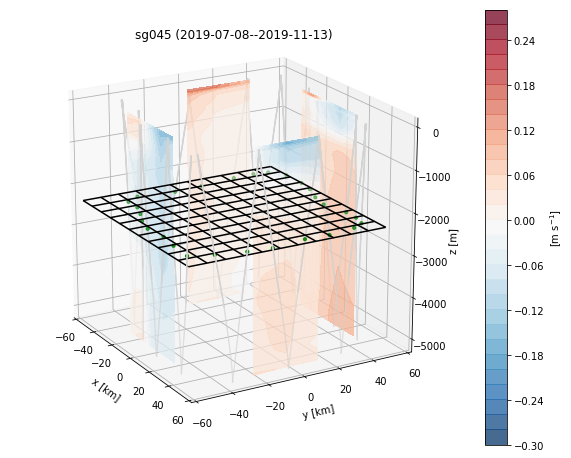

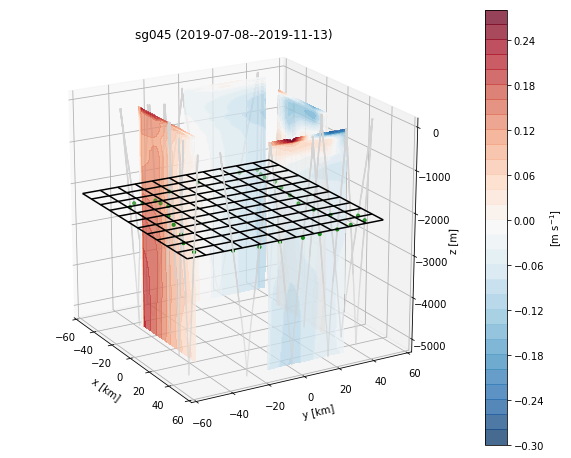

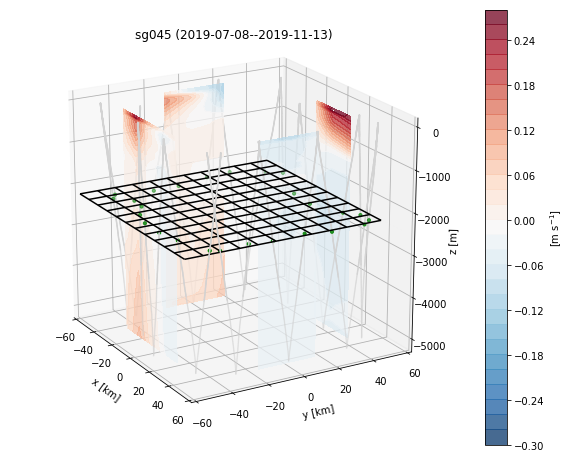

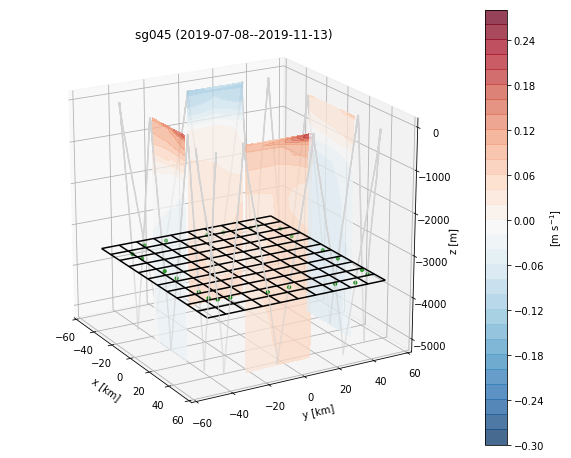

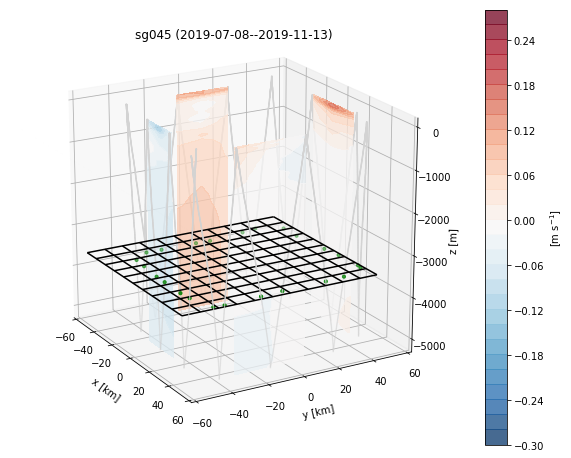

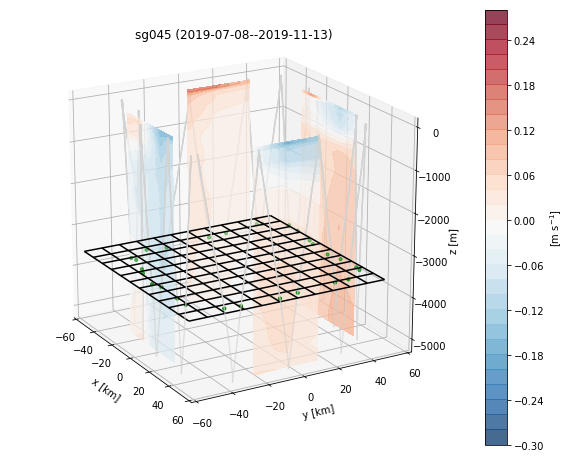

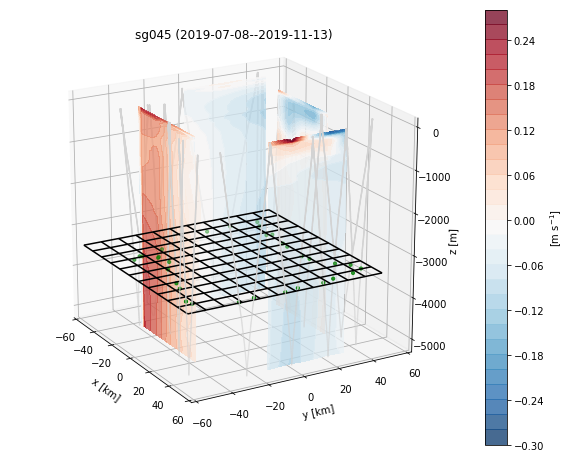

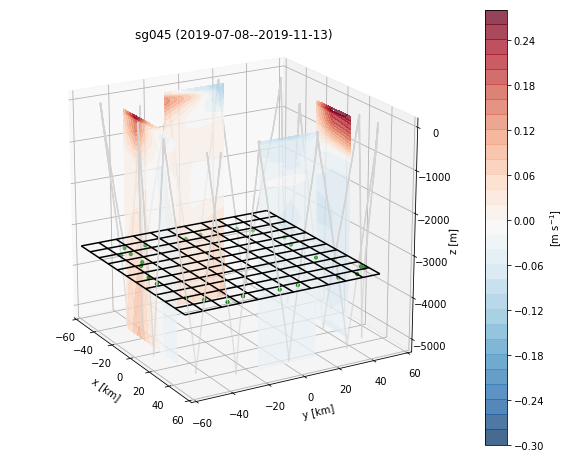

In [47]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
matplotlib.rcParams['figure.figsize'] = (10,8)

sigi_0 = [27.50, 28.00, 28.10]  
intp_t = [[1], [2], [3]]
intp_s = [[1], [2], [3]]

namei = ['sg037_box_1', 'sg037_box_2', 'sg037_box_3', 'sg037_box_4']
plot_3d = 1
fit = [[1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]
for g in range(len(sigi_0)):  # loop over 
    sigi = sigi_0[g]
    for m in range(5):  # loop over the number of times the box has been completed 
        intp_x_i = []
        intp_y_i = []
        intp_z_i = []
    
        if plot_3d:
            fig = plt.figure()
            ax = fig.gca(projection='3d')
            lvs = np.arange(-.3,.3,.02)
        # --- in profiles (u_1)
        ind_p_in = np.where((profile_tags >= np.nanmin(u_1_no[u_1_br[m]:u_1_br[m+1]])) & (profile_tags <= np.nanmax(u_1_no[u_1_br[m]:u_1_br[m+1]])) )[0]
        ind_p_in = np.concatenate((ind_p_in, [ind_p_in[-1] + 1]))
        for p in range(len(ind_p_in)): # loop over each profile in this box side 
            this_x = x_d[:, ind_p_in[p]]
            this_y = y_d[:, ind_p_in[p]]
            this_g = neutral_density[:, ind_p_in[p]]
            this_s = sa[:, ind_p_in[p]]
            this_t = ct[:, ind_p_in[p]]
            intp_t[g].append(np.interp(sigi, this_g[20:-20], this_t[20:-20]))
            intp_s[g].append(np.interp(sigi, this_g[20:-20], this_s[20:-20]))
        
            intp_x_i.append(np.interp(sigi, this_g[20:-20], this_x[20:-20]))
            intp_y_i.append(np.interp(sigi, this_g[20:-20], this_y[20:-20]))
            intp_z_i.append(np.interp(sigi, this_g[20:-20], grid[20:-20]))
            if plot_3d:
                ax.scatter3D(x_d[:, ind_p_in[p]]/1000, 
                             y_d[:, ind_p_in[p]]/1000, -1*grid, s=.5,color='#D3D3D3', zorder=2, zdir='z',linewidth=0.75) 
        # contour velocities 
        this_y1 = y_1[u_1_br[m]:u_1_br[m+1]]
        this_u1 = u_1[:, u_1_br[m]:u_1_br[m+1]]
        if plot_3d:
            cset = ax.contourf(np.ones(np.shape(this_u1))*this_u1, np.tile(this_y1,(len(grid),1))/1000, 
                               np.transpose(np.tile(-1*grid,(len(this_y1),1))), 
                               zdir='x', offset=np.nanmean(x_d[:, ind_p_in]/1000), levels=lvs, cmap=cm.RdBu_r, zorder=1, linewidth=1, alpha=0.75)

        # --- in profiles (u_3)
        ind_p_in = np.where((profile_tags >= np.nanmin(u_3_no[u_3_br[m]:u_3_br[m+1]])) & (profile_tags <= np.nanmax(u_3_no[u_3_br[m]:u_3_br[m+1]])) )[0]
        ind_p_in = np.concatenate((ind_p_in, [ind_p_in[-1] + 1])) 
        for p in range(len(ind_p_in)):  # loop over each profile in this box side 
            this_x = x_d[:, ind_p_in[p]]
            this_y = y_d[:, ind_p_in[p]]
            this_g = neutral_density[:, ind_p_in[p]]
            this_s = sa[:, ind_p_in[p]]
            this_t = ct[:, ind_p_in[p]]
            intp_t[g].append(np.interp(sigi, this_g[20:-20], this_t[20:-20]))
            intp_s[g].append(np.interp(sigi, this_g[20:-20], this_s[20:-20]))
        
            intp_x_i.append(np.interp(sigi, this_g[20:-20], this_x[20:-20]))
            intp_y_i.append(np.interp(sigi, this_g[20:-20], this_y[20:-20]))
            intp_z_i.append(np.interp(sigi, this_g[20:-20], grid[20:-20]))
            if plot_3d:
                ax.scatter3D(x_d[:, ind_p_in[p]]/1000, 
                             y_d[:, ind_p_in[p]]/1000, -1*grid, s=.5,color='#D3D3D3', zorder=2, zdir='z',linewidth=0.75) 
        # contour velocities 
        this_y3 = y_3[u_3_br[m]:u_3_br[m+1]]
        this_u3 = u_3[:, u_3_br[m]:u_3_br[m+1]]
        if plot_3d:
            cset = ax.contourf(np.ones(np.shape(this_u3))*this_u3, np.tile(this_y3,(len(grid),1))/1000, 
                               np.transpose(np.tile(-1*grid,(len(this_y3),1))), 
                               zdir='x', offset=np.nanmean(x_d[:, ind_p_in]/1000), levels=lvs, cmap=cm.RdBu_r, zorder=1, linewidth=1, alpha=0.75)

        # --- in profiles (v_0)
        ind_p_in = np.where((profile_tags >= np.nanmin(v_0_no[v_0_br[m]:v_0_br[m+1]])) & (profile_tags <= np.nanmax(v_0_no[v_0_br[m]:v_0_br[m+1]])) )[0]
        ind_p_in = np.concatenate((ind_p_in, [ind_p_in[-1] + 1]))
        for p in range(len(ind_p_in)):  # loop over each profile in this box side 
            this_x = x_d[:, ind_p_in[p]]
            this_y = y_d[:, ind_p_in[p]]
            this_g = neutral_density[:, ind_p_in[p]]
            this_s = sa[:, ind_p_in[p]]
            this_t = ct[:, ind_p_in[p]]
            intp_t[g].append(np.interp(sigi, this_g[20:-20], this_t[20:-20]))
            intp_s[g].append(np.interp(sigi, this_g[20:-20], this_s[20:-20]))
        
            intp_x_i.append(np.interp(sigi, this_g[20:-20], this_x[20:-20]))
            intp_y_i.append(np.interp(sigi, this_g[20:-20], this_y[20:-20]))
            intp_z_i.append(np.interp(sigi, this_g[20:-20], grid[20:-20]))
            if plot_3d:
                ax.scatter3D(x_d[:, ind_p_in[p]]/1000, 
                             y_d[:, ind_p_in[p]]/1000, -1*grid, s=.5,color='#D3D3D3', zorder=2, zdir='z',linewidth=0.75) 
        # contour velocities 
        this_x0 = x_0[v_0_br[m]:v_0_br[m+1]]
        this_v0 = v_0[:, v_0_br[m]:v_0_br[m+1]]
        if plot_3d:
            cset = ax.contourf(np.tile(this_x0,(len(grid),1))/1000, np.ones(np.shape(this_v0))*this_v0, 
                               np.transpose(np.tile(-1*grid,(len(this_x0),1))), 
                               zdir='y', offset=np.nanmean(y_d[:, ind_p_in]/1000), levels=lvs, cmap=cm.RdBu_r, zorder=1, linewidth=1, alpha=0.75)
    
        # --- in profiles (v_2)
        ind_p_in = np.where((profile_tags >= np.nanmin(v_2_no[v_2_br[m]:v_2_br[m+1]])) & (profile_tags <= np.nanmax(v_2_no[v_2_br[m]:v_2_br[m+1]])) )[0]
        ind_p_in = np.concatenate((ind_p_in, [ind_p_in[-1] + 1]))
        for p in range(len(ind_p_in)):  # loop over each profile in this box side 
            this_x = x_d[:, ind_p_in[p]]
            this_y = y_d[:, ind_p_in[p]]
            this_g = neutral_density[:, ind_p_in[p]]
            this_s = sa[:, ind_p_in[p]]
            this_t = ct[:, ind_p_in[p]]
            intp_t[g].append(np.interp(sigi, this_g[20:-20], this_t[20:-20]))
            intp_s[g].append(np.interp(sigi, this_g[20:-20], this_s[20:-20]))
        
            intp_x_i.append(np.interp(sigi, this_g[20:-20], this_x[20:-20]))
            intp_y_i.append(np.interp(sigi, this_g[20:-20], this_y[20:-20]))
            intp_z_i.append(np.interp(sigi, this_g[20:-20], grid[20:-20]))
            if plot_3d:
                ax.scatter3D(x_d[:, ind_p_in[p]]/1000, 
                             y_d[:, ind_p_in[p]]/1000, -1*grid, s=.5,color='#D3D3D3', zorder=2, zdir='z',linewidth=0.75) 
        # contour velocities 
        this_x2 = x_2[v_2_br[m]:v_2_br[m+1]]
        this_v2 = v_2[:, v_2_br[m]:v_2_br[m+1]]
        if plot_3d:
            cset = ax.contourf(np.tile(this_x2,(len(grid),1))/1000, np.ones(np.shape(this_v2))*this_v2, 
                               np.transpose(np.tile(-1*grid,(len(this_x2),1))), 
                               zdir='y', offset=np.nanmean(y_d[:, ind_p_in]/1000), levels=lvs, cmap=cm.RdBu_r, zorder=1, linewidth=1, alpha=0.75)    
    

        # do fit
        xs = np.array(intp_x_i)
        ys = np.array(intp_y_i)
        zs = -1*np.array(intp_z_i)
        # print(xs)
        tmp_A = []
        tmp_b = []
        for i in range(len(xs)):
            tmp_A.append([xs[i], ys[i], 1])
            tmp_b.append(zs[i])
        b = np.matrix(tmp_b).T
        A = np.matrix(tmp_A)
        fit[g][m] = ((A.T * A).I * A.T * b)

        if plot_3d:
            ax.scatter3D(np.array(intp_x_i)/1000, np.array(intp_y_i)/1000, 
                         -1*np.array(intp_z_i), s=10, color='g', zorder=3)   
        
            # plot plane
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            X,Y = np.meshgrid(np.arange(xlim[0], xlim[1], 10), np.arange(ylim[0], ylim[1], 10))
            Z = np.zeros(X.shape)
            this_fit = fit[g][m]
            for r in range(X.shape[0]):
                for c in range(X.shape[1]):
                    Z[r,c] = this_fit[0] * X[r,c] + this_fit[1] * Y[r,c] + this_fit[2]
            ax.plot_wireframe(X,Y,Z, color='k')
            ax.set_xlim([-60, 60])
            ax.set_ylim([-60, 60])
            ax.set_zlim([-5200, 100])
            ax.set_xlabel('x [km]')
            ax.set_ylabel('y [km]')
            ax.set_zlabel('z [m]')
            ax.set_title('sg045 (' + str(t_s) + '--' + str(t_e) + ')')
            ax.view_init(20,-30)
            fig.colorbar(cset, label='[m s$^{-1}$]')
            plot_pro(ax)
            # fig.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/" + namei[m] +".jpg", dpi=300)

In [35]:
print(fit[0][4][0])

[[-0.0006208]]


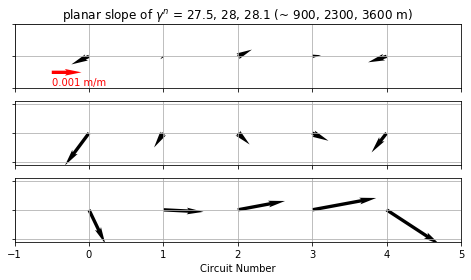

In [52]:
matplotlib.rcParams['figure.figsize'] = (8,4)
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
for i in range(5):
    ax1.quiver(i, 0, 1000*np.array(fit[0][i][0]), 1000*np.array(fit[0][i][1]), scale=15, color='k', headwidth=2)
    ax2.quiver(i, 0, 1000*np.array(fit[1][i][0]), 1000*np.array(fit[1][i][1]), scale=15, color='k', headwidth=2)
    ax3.quiver(i, 0, 1000*np.array(fit[2][i][0]), 1000*np.array(fit[2][i][1]), scale=15, color='k', headwidth=2)
ax1.quiver(-0.5, -.025, 1000*0.001, 0, color='r', scale=15, headwidth=2)
ax1.text(-0.5, -.045, '0.001 m/m', color='r')
ax1.set_xlim([-1, 5]) 
ax1.set_ylim([-.05, 0.05])
ax1.set_yticklabels([])
ax2.set_yticklabels([])
ax3.set_yticklabels([])
ax3.set_xlabel('Circuit Number')
ax1.set_title('planar slope of $\gamma^n$ = 27.5, 28, 28.1 (~ 900, 2300, 3600 m)')
ax1.grid()
ax2.grid()
plot_pro(ax3)
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/sg037_planar_slope.jpg", dpi=300)

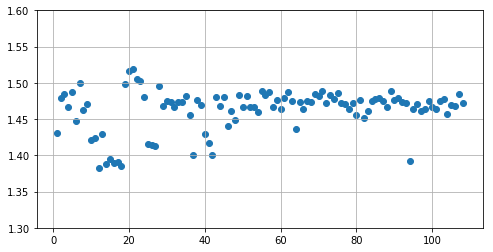

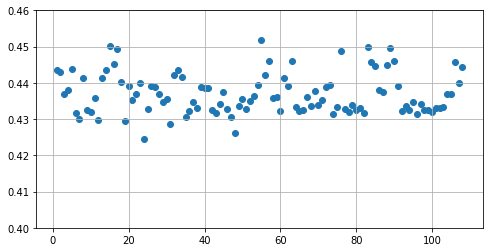

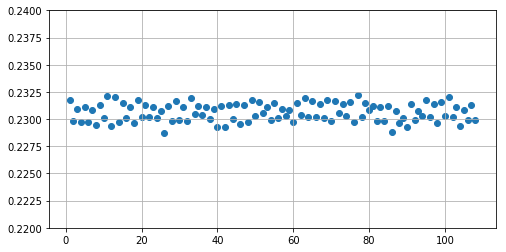

In [18]:
# spice along isopycnal
yyll = [1.3, 1.6], [.4, .46], [.22, .24]
for i in range(len(intp_s)):
    intp_s[i][0] = np.nan
    intp_t[i][0] = np.nan
    spicee = gsw.spiciness2(np.array(intp_s[i]), np.array(intp_t[i]))
    f, ax = plt.subplots()
    ax.scatter(np.arange(len(spicee)), spicee)
    ax.set_ylim(yyll[i])
    plot_pro(ax)    

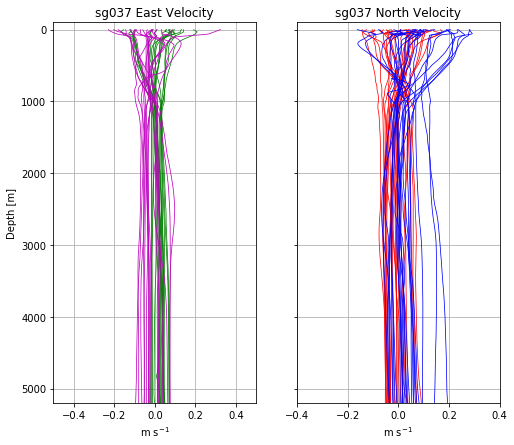

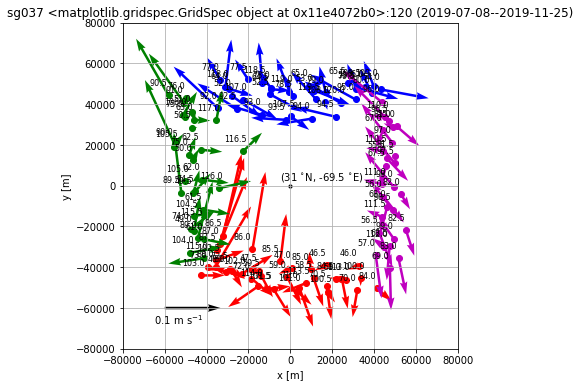

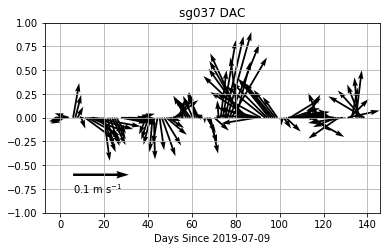

()

In [17]:
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# for i in range(np.shape(u)[1]):
#     if i < np.nansum(box_side_0[0,:] == 1):
#         ax1.plot(u[:, i], grid, color='g')
#     else:
#         ax1.plot(u[:, i], grid, color='m')    
# ax1.set_xlim([-.2, .2])    
# ax1.grid()
# for i in range(np.shape(v)[1]):
#     if i < np.nansum(box_side_0[0,:] == 0):
#         ax2.plot(v[:, i], grid, color='r')
#     else:
#         ax2.plot(v[:, i], grid, color='b')    
# ax2.set_xlim([-.2, .2])     
# ax2.invert_yaxis()    
# plot_pro(ax2)    

ref_lat = 31.0
ref_lon = -69.5
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (dg_v_lon - ref_lon)
y = 1852 * 60 * (dg_v_lat - ref_lat)
x_d = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (lon - ref_lon)
y_d = 1852 * 60 * (lat - ref_lat)

matplotlib.rcParams['figure.figsize'] = (8,7)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for i in range(np.shape(u)[1]):
    if i < np.nansum(box_side_0[0,:] == 1):
        ax1.plot(u[:, i], grid, color='g', linewidth=0.75)
    else:
        ax1.plot(u[:, i], grid, color='m', linewidth=0.75)    
ax1.set_xlim([-.5, .5])   
ax1.set_ylim([-100, 5200])
ax1.set_title('sg037 East Velocity')
ax1.set_xlabel('m s$^{-1}$')
ax1.set_ylabel('Depth [m]')
ax1.grid()
for i in range(np.shape(v)[1]):
    if i < np.nansum(box_side_0[0,:] == 0):
        ax2.plot(v[:, i], grid, color='r', linewidth=0.75)
    else:
        ax2.plot(v[:, i], grid, color='b', linewidth=0.75)    
ax2.set_xlim([-.4, .4])   
ax2.set_title('sg037 North Velocity')
ax2.set_xlabel('m s$^{-1}$')
ax2.invert_yaxis()  
plot_pro(ax2)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg037_uv.jpg", dpi=300)

matplotlib.rcParams['figure.figsize'] = (6,6)
f, ax3 = plt.subplots()
# ax3.scatter(x, y)
for j in range(len(dg_v_dive_no_0)):
    ax3.text(x[j] - 9000, y[j] + 5000, str(dg_v_dive_no_0[j]), fontsize=8)
ax3.scatter(x[box_side_0[0,:] == 0], y[box_side_0[0,:] == 0], color='r')
ax3.scatter(x[box_side_0[0,:] == 2], y[box_side_0[0,:] == 2], color='b')
ax3.scatter(x[box_side_0[0,:] == 1], y[box_side_0[0,:] == 1], color='g')
ax3.scatter(x[box_side_0[0,:] == 3], y[box_side_0[0,:] == 3], color='m')

cmap = plt.get_cmap('jet', len(dg_mw_time_0))
dg_mw_time_order_i = np.argsort(dg_mw_time_0)
dg_mw_time_order = dg_mw_time_0[dg_mw_time_order_i]
dace_mw_order = dace_mw_0[dg_mw_time_order_i]
dacn_mw_order = dacn_mw_0[dg_mw_time_order_i]
x_order = x[dg_mw_time_order_i]
y_order = y[dg_mw_time_order_i]
# for j in range(len(dg_mw_time_0)):
#     dq = ax3.quiver(x_order[j], y_order[j], dace_mw_order[j], dacn_mw_order[j], color='k', scale=0.6)
ax3.quiver(x[box_side_0[0,:] == 0], y[box_side_0[0,:] == 0],
          dace_mw_0[box_side_0[0,:] == 0], dacn_mw_0[box_side_0[0,:] == 0], color='r', scale=0.6)
ax3.quiver(x[box_side_0[0,:] == 2], y[box_side_0[0,:] == 2], 
          dace_mw_0[box_side_0[0,:] == 2], dacn_mw_0[box_side_0[0,:] == 2], color='b', scale=0.6)
ax3.quiver(x[box_side_0[0,:] == 1], y[box_side_0[0,:] == 1], 
          dace_mw_0[box_side_0[0,:] == 1], dacn_mw_0[box_side_0[0,:] == 1], color='g', scale=0.6)
ax3.quiver(x[box_side_0[0,:] == 3], y[box_side_0[0,:] == 3], 
          dace_mw_0[box_side_0[0,:] == 3], dacn_mw_0[box_side_0[0,:] == 3], color='m', scale=0.6)
ax3.quiver(-60000, -60000, 0.1, 0, color='k', scale=.6)
ax3.text(-65000, -68000, '0.1 m s$^{-1}$')
ax3.scatter(0, 0, 10, color='k')
ax3.text(-5000, 3000, '(31 $^{\circ}$N, -69.5 $^{\circ}$E)')
ax3.set_xlim([-80000, 80000])
ax3.set_ylim([-80000, 80000])
ax3.set_xlabel('x [m]')
ax3.set_ylabel('y [m]')
ax3.set_title('sg037 ' + str(gs) + ':' + str(ge) + ' (' + str(t_s) + '--' + str(t_e) + ')')
plot_pro(ax3)    
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg037_dac.jpg", dpi=300)

matplotlib.rcParams['figure.figsize'] = (6,3.5)
import datetime 
f, ax = plt.subplots()
dg_mw_time_date = []
for j in range(len(dg_mw_time_0)):
    dg_mw_time_date.append(datetime.date.fromordinal(np.int(np.round(dg_mw_time_order[j]))))
ax.quiver(dg_mw_time_order - dg_mw_time_order[0], np.zeros(len(dg_mw_time_order)), dace_mw_order, dacn_mw_order, scale=0.6)
ax.quiver(dg_mw_time_order[5] - dg_mw_time_order[0], -.6, 0.1, 0, color='k', scale=.6)
ax.text(dg_mw_time_order[5] - dg_mw_time_order[0], -.8, '0.1 m s$^{-1}$')
ax.set_ylim([-1, 1])
ax.set_xlabel('Days Since ' + str(dg_mw_time_date[0]))
ax.set_title('sg037 DAC')
plot_pro(ax)
# f.savefig("/Users/jake/Documents/baroclinic_modes/Meetings/meeting_19_09_04/sg037_dac_time.jpg", dpi=300)


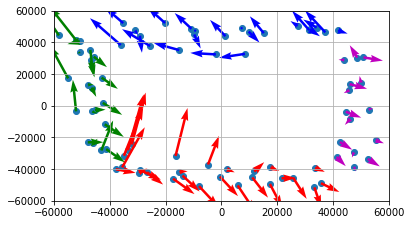

()

In [40]:
x = 1852 * 60 * np.cos(np.deg2rad(ref_lat)) * (dg_v_lon - ref_lon)
y = 1852 * 60 * (dg_v_lat - ref_lat)

f, ax = plt.subplots()
ax.scatter(x, y)
ax.quiver(x[box_side_0[0,:] == 0], y[box_side_0[0,:] == 0], 
          dace_mw_0[box_side_0[0,:] == 0], dacn_mw_0[box_side_0[0,:] == 0], color='r', scale=1)
ax.quiver(x[box_side_0[0,:] == 2], y[box_side_0[0,:] == 2], 
          dace_mw_0[box_side_0[0,:] == 2], dacn_mw_0[box_side_0[0,:] == 2], color='b', scale=1)
ax.quiver(x[box_side_0[0,:] == 1], y[box_side_0[0,:] == 1], 
          dace_mw_0[box_side_0[0,:] == 1], dacn_mw_0[box_side_0[0,:] == 1], color='g', scale=1)
ax.quiver(x[box_side_0[0,:] == 3], y[box_side_0[0,:] == 3], 
          dace_mw_0[box_side_0[0,:] == 3], dacn_mw_0[box_side_0[0,:] == 3], color='m', scale=1)
ax.set_xlim([-60000, 60000])
ax.set_ylim([-60000, 60000])
plot_pro(ax)

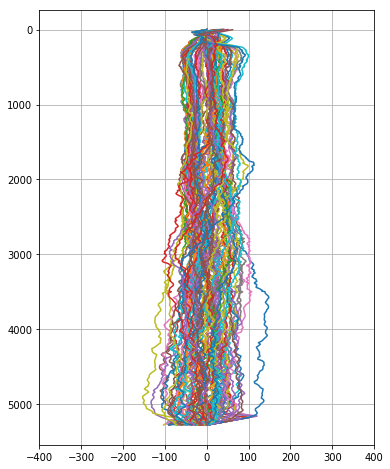

()

In [18]:
matplotlib.rcParams['figure.figsize'] = (6, 8)
f, ax = plt.subplots()
for i in range(np.shape(eta_alt_3)[1]):
    ax.plot(eta_alt_3[:, i], grid)
    # ax.plot(Eta_m_prof[:, i], grid, color='k', linestyle='--')
ax.set_xlim([-400, 400])
ax.invert_yaxis()    
plot_pro(ax)

In [86]:
box_side_0[0][good_v]

array([ 3.,  3.,  3.,  3.,  3.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.])

In [20]:
# FILTER VELOCITY PROFILES IF THEY ARE TOO NOISY / BAD -- ALSO HAVE TO REMOVE EQUIVALENT ETA PROFILE (non-ind profiles)
# select only velocity profiles that seem reasonable
# criteria are slope of v (dont want kinks)
# criteria: limit surface velocity to greater that 40cm/s
good_v = np.zeros(np.shape(dg_v_0)[1], dtype=bool)
for i in range(np.shape(dg_v_0)[1]):
    dv_dz = np.gradient(dg_v_0[20:-20, i], -1 * grid[20:-20])
    print(np.nanmax(np.abs(dv_dz)))
    if (np.nanmax(np.abs(dv_dz)) < 0.02) & (np.nanmax(np.abs(eta_alt_3[20:-20, i])) < 1000):  # 0.0225
        good_v[i] = True
# good_v[np.abs(dg_v_0[5,:]) > 1] = False
        
avg_sig = avg_sig0_per_dep[:, good_v]
eta_alt = eta_alt_3[:, good_v]
dace_mw = dace_mw_0[good_v]
dacn_mw = dacn_mw_0[good_v]
dg_v = dg_v_0[:, good_v]
dg_v_e = dg_v_e_0[:, good_v]
dg_v_n = dg_v_n_0[:, good_v]
dg_mw_time = dg_mw_time_0[good_v]
dg_v_dive_no = dg_v_dive_no_0[good_v]
num_mw_profs = np.shape(eta_alt)[1]
box_side_o = box_side_0[0][good_v]

# unfiltered u,v profiles (with dac pairs)
gpu = np.where(~np.isnan(u[50, :]))[0]
gpv = np.where(~np.isnan(v[50, :]))[0]
u_o = u[:, gpu].copy()
v_o = v[:, gpv].copy()
u_prof_o = u_prof[gpu].copy()
v_prof_o = v_prof[gpv].copy() 
dace_u_side_o = dace_u_side[gpu].copy()
dacn_u_side_o = dacn_u_side[gpu].copy()
dace_v_side_o = dace_v_side[gpv].copy()
dacn_v_side_o = dacn_v_side[gpv].copy()

# Smooth DG N2 profiles
dg_avg_N2_coarse = np.nanmean(dg_N2, axis=1)
dg_avg_N2_coarse[np.isnan(dg_avg_N2_coarse)] = dg_avg_N2_coarse[~np.isnan(dg_avg_N2_coarse)][0] - 1*10**(-5)
dg_avg_N2 = savgol_filter(dg_avg_N2_coarse, 15, 3)

nan
0.000913526754526
0.000396803605261
0.00026253682178
nan
nan
5.37128402441e-05
0.000211102710257
0.000164486045096
nan
nan
0.000366302275752
0.000542301063059
0.000157305067472
nan
nan
0.000321191575887
0.00190641200248
0.000880413213747
0.00152191942812
0.000579460368271
nan
nan
0.000173508748855
0.000372836044831
0.000199634813332
nan
nan
0.000593782270036
0.000229957067352
0.000149514303571
nan
nan
0.00018516917488
0.000606818761726
0.00042653278345
nan
nan
0.000628928693291
0.000246003822904
0.000116435818511
0.000284312206881
0.000209275709481
nan
nan
0.000238357960253
0.000624832222588
0.000357798239762
0.000231863359969
0.000131651041591
0.000640675806515
0.000536993974483
nan
nan
0.000266907175126
0.000170756395618
0.000243216528293
0.000342030899257
0.000316027583917
nan
nan
0.000206276934128
nan
nan
0.0001137071674
0.000184585298457
0.000173761824267
nan
nan
0.000479784602878
0.0008116472481
0.00050870639036
nan
nan
0.000162641122243
0.000383706630177
0.000195296478618
0.

/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: All-NaN slice encountered
/Users/jake/anaconda/envs/geo_env/lib/python3.6/site-packages/ipykernel/__main__.py:38: RuntimeWarning: Mean of empty slice


In [31]:
print(u_prof_o)
print(v_prof_o)
np.shape(v_prof_o)

[  49.5   50.    50.5   55.5   56.    56.5   61.5   62.    62.5   67.5
   68.    68.5   74.5   75.    75.5   81.5   82.    82.5   89.5   90.
   90.5   96.5   97.    97.5   98.    98.5  104.5  105.   105.5]
[  46.5   47.    47.5   52.5   53.    53.5   58.5   59.    59.5   64.5
   65.    65.5   70.5   71.    71.5   72.    72.5   77.5   78.    78.5
   79.    79.5   84.5   85.    85.5   86.    86.5   87.    87.5   92.5
   93.    93.5   94.    94.5  100.5  101.   101.5  102.   102.5  107.5
  108.   108.5]


(42,)

In [23]:
# SAVING 
savee = 1
if savee > 0:
    my_dict = {'depth': grid, 'raw_profile_tags': profile_tags, 'sa': sa, 'ct': ct, 'gamma': neutral_density, 
               'prof_lon': lon, 'prof_lat': lat,
               'profile_time': time_rec_bin, 'ref_lon': ref_lon, 'ref_lat': ref_lat,  
               'lon_lim': lon_lim, 'lat_lim': lat_lim,
               'N2_by_season_quad': N2, 'bckgrd_sa': salin_avg, 'bckgrd_ct': cons_t_avg,
               'bckgrd_theta': theta_avg, 'bckgrd_gamma': sigma_theta_avg, 'mw_time': dg_mw_time_0, 'mw_lon': prof_lon_i,
               'mw_lat': prof_lat_i, 'mw_ct': avg_ct_per_dep, 'mw_sa': avg_sa_per_dep, 'mw_gamma': avg_sig0_per_dep,
               'eta_1': eta_alt_0, 'eta_2': eta_alt_2, 'eta_3': eta_alt_3, 'eta_per_1': eta_per_prof, 
               'eta_per_3': eta_per_prof_3, 'mw_prof': dg_v_dive_no_0,
               'good_v_ind': good_v, 'mw_time_good': dg_mw_time,
               'mw_gamma_good': avg_sig, 'eta_1_good': eta_alt_0[:, good_v], 'eta_2_good': eta_alt_2[:, good_v],
               'eta_3_good': eta_alt_3[:, good_v], 'dac_e_mw': dace_mw, 'dac_n_mw': dacn_mw,
               'dg_v_good': dg_v, 'dg_v': dg_v_0, 'dg_v_e_good': dg_v_e, 'dg_v_n_good': dg_v_n, 
               'mw_prof_good': dg_v_dive_no, 'box_side_no': box_side_o,
               'PE_per_prof': PE_per_mass_all, 'PE_per_prof_time': PE_all_time, 'PE_per_prof_tag': PE_all_tags,
               'u_profiles': u_o, 'dac_e_u_profiles': dace_u_side_o, 'dac_n_u_profiles': dacn_u_side_o, 
               'v_profiles': v_o, 'dac_e_v_profiles': dace_v_side_o, 'dac_n_v_profiles': dacn_v_side_o,
               'u_prof_no': u_prof_o, 'v_prof_no': v_prof_o}               
    output = open('/Users/jake/Documents/baroclinic_modes/DG/sg037_2019_initial_processing.pkl', 'wb')
    pickle.dump(my_dict, output)
    output.close()
    
    # 'background_indices': bckgrds, 'background key': bckgrds_info, 'bd1': bd1, 'bd2': bd2,

In [24]:
# SAVE as netcdf 
from netCDF4 import Dataset

time_order_i = np.argsort(dg_mw_time)
mw_time_order = dg_mw_time[time_order_i]
mw_prof_order = dg_v_dive_no[time_order_i]
u_time = np.nan * np.ones(len(u_prof_o))
v_time = np.nan * np.ones(len(v_prof_o))
# order u, v velocities and pair with times 
for i in range(len(u_prof_o)):
    indi = np.where(mw_prof_order == u_prof_o[i])[0]
    u_time[i] = mw_time_order[indi]  
for i in range(len(v_prof_o)):
    indi = np.where(mw_prof_order == v_prof_o[i])[0]
    v_time[i] = mw_time_order[indi] 

save_net = 1
if save_net > 0:

    dataset = Dataset('/Users/jake/Documents/lde_2019.nc', 'w', format='NETCDF4_CLASSIC')
    # -- create dimensions 
    dep_dim = dataset.createDimension('dep_dim', len(grid))
    # individual profiles 
    profile_dim = dataset.createDimension('prof_dim', np.shape(neutral_density)[1])
    # u,v profiles
    u_dim = dataset.createDimension('u_dim', np.shape(u_o)[1])
    v_dim = dataset.createDimension('v_dim', np.shape(v_o)[1])
    # N2 by quadrant 
    n2_dim = dataset.createDimension('n2_dim', np.shape(N2)[1])
    
    # assign variables 
    bin_dep_out = dataset.createVariable('depth', np.float64, ('dep_dim'))
    bin_dep_out[:] = grid
    gamma_out = dataset.createVariable('gamma', np.float64, ('dep_dim', 'prof_dim'))
    gamma_out[:] = neutral_density
    t_out = dataset.createVariable('temp', np.float64, ('dep_dim', 'prof_dim'))
    t_out[:] = t
    s_out = dataset.createVariable('salin', np.float64, ('dep_dim', 'prof_dim'))
    s_out[:] = s
    ct_out = dataset.createVariable('ct', np.float64, ('dep_dim', 'prof_dim'))
    ct_out[:] = ct
    sa_out = dataset.createVariable('sa', np.float64, ('dep_dim', 'prof_dim'))
    sa_out[:] = sa
    time_out = dataset.createVariable('profile_time', np.float64, ('prof_dim'))
    time_out[:] = time_rec_bin
    n2_out = dataset.createVariable('N2', np.float64, ('dep_dim', 'n2_dim'))
    n2_out[:] = N2
    u_out = dataset.createVariable('u', np.float64, ('dep_dim', 'u_dim'))
    u_out[:] = u_o
    v_out = dataset.createVariable('v', np.float64, ('dep_dim', 'v_dim'))
    v_out[:] = v_o
    u_t_out = dataset.createVariable('u_time', np.float64, ('u_dim'))
    u_t_out[:] = u_time
    v_t_out = dataset.createVariable('v_time', np.float64, ('v_dim'))
    v_t_out[:] = v_time
    dataset.close()

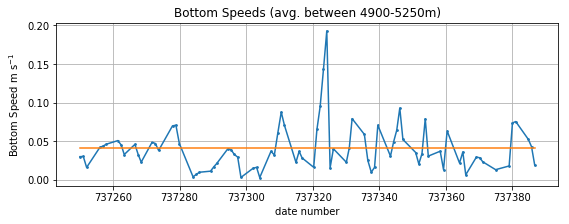

In [42]:
uv_time = np.concatenate((u_time, v_time), axis=0)
uv_profs = np.concatenate((u_o, v_o), axis=1)
uv_time_sort = np.argsort(uv_time)
uv_profs_time_order = uv_profs[:, uv_time_sort]
uv_times_order = uv_time[uv_time_sort]
bot_vel_mean = np.nanmean(np.abs(uv_profs_time_order[-20:, :]), axis=0)
matplotlib.rcParams['figure.figsize'] = (9,3)
f, ax = plt.subplots()
ax.plot(uv_times_order, bot_vel_mean)
ax.plot(uv_times_order, np.nanmean(bot_vel_mean)*np.ones(len(uv_times_order)))
ax.scatter(uv_times_order, bot_vel_mean, s=3)
ax.set_xlabel('date number')
ax.set_ylabel('Bottom Speed m s$^{-1}$')
ax.set_title('Bottom Speeds (avg. between 4900-5250m)')
plot_pro(ax)
f.savefig("/Users/jake/Documents/baroclinic_modes/dissertation/sg037_bottom_velocites.jpg", dpi=300)

In [40]:
grid[-20:]

array([4900, 4920, 4940, 4960, 4980, 5000, 5020, 5040, 5060, 5080, 5100,
       5120, 5140, 5160, 5180, 5200, 5220, 5240, 5260, 5280], dtype=uint16)